# DD stage specific DE gene analysis


In [1]:
library(limma)
library(dplyr)
library(patchwork)
library(ggplot2)
library(ggrepel)
library(clusterProfiler)
library(AnnotationHub) 
library(biomaRt)

volcano <- function(diffsig, foldChange, padj, title="stage specific DE genes"){ 
    #diffsig <- data.frame(diffsig)
    diffsig$Significant <- ifelse((diffsig$P.Value < padj & abs(diffsig$logFC)> foldChange), ifelse(diffsig$logFC > foldChange,"Up","Down"), "NotSig")
    
    p <- ggplot(diffsig, aes(logFC, -log10(P.Value)))+
      geom_point(aes(col=Significant))+
      scale_color_manual(values=c("#0072B5","grey","#BC3C28"))+
      labs(title = " ")+
      geom_vline(xintercept=c(-foldChange,foldChange), colour="black", linetype="dashed")+
      geom_hline(yintercept = -log10(padj),colour="black", linetype="dashed")+
      theme(plot.title = element_text(size = 16, hjust = 0.5, face = "bold"))+
      labs(x="log2(FoldChange)",y="-log10(Pvalue)")+
      theme(axis.text=element_text(size=13),axis.title=element_text(size=13))+
      str(diffsig, max.level = c(-1, 1))+theme_bw() + ggtitle(paste0(title, " UP genes:", dim(subset(diffsig, Significant=="Up"))[1]))
    
    return (p)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




clusterProfiler v3.16.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, 

In [215]:
hub <- AnnotationHub() #建立AnnotationHub对象（视人品，网不行加载不了）
# unique(hub$species) #查看AnonotationHub里面物种
hub$species[which(hub$species=="Solanum")] #看AnonotationHub里是否包含想要的物种
# Solanum是番茄的拉丁名
query(hub, "Solanum")  #查看该物种信息
hub[hub$species=="Solanum" & hub$rdataclass == "OrgDb"] #OrgDb属于rdataclass中，因此查看下该物种有没有OrgDb
Solanum.OrgDb <- hub[["AH80808"]]#AH59087是番茄对应的编号


using temporary cache /var/folders/s6/8xqxsbh11nl91f72l5vsz7fh0000gn/T//RtmpR5XFxW/BiocFileCache

snapshotDate(): 2020-04-27



character(0)

AnnotationHub with 8 records
# snapshotDate(): 2020-04-27
# $dataprovider: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/, Inparanoid8
# $species: Solanum tuberosum, Solanum lycopersicum, Solanum pennellii, Sola...
# $rdataclass: OrgDb, Inparanoid8Db
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH10593"]]' 

            title                                             
  AH10593 | hom.Solanum_lycopersicum.inp8.sqlite              
  AH10606 | hom.Solanum_tuberosum.inp8.sqlite                 
  AH80691 | org.Solanum_pennelli.eg.sqlite                    
  AH80692 | org.Solanum_pennellii.eg.sqlite                   
  AH80747 | org.Solanum_tuberosum.eg.sqlite                   
  AH80807 | org.Solanum_esculentum.eg.sqlite                  
  AH80808 | org.Solanum_lycopersicum.eg.sqlite                
  AH80809 | org.Solanum_lycopersi

AnnotationHub with 0 records
# snapshotDate(): 2020-04-27

downloading 1 resources

retrieving 1 resource

loading from cache

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following object is masked from ‘package:AnnotationHub’:

    cache


Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:clusterProfiler’:

    rename


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:base’:

    expand.grid



Attaching package: ‘IRanges’


The following object is masked from ‘package:clusterProfiler’:

    slice


The following objects are masked from ‘package:dplyr’:

    collapse, desc, sl

In [2]:
CC_FC <- read.table("CC_overlap_log2fc.csv", header=TRUE, row.names=1, sep="\t")
colnames(CC_FC) <- paste0("HAG", gsub("^([[:alpha:]]*).[[:alpha:]].", '', colnames(CC_FC)))
CC_FC_cm <- readRDS(paste0("mfuzz_data/CC_FC_cm_cluster18.rds"))
CCmain <- c("C18", "C16", "C13", "C9", "C5", "C6", "C11", "C8", "C4")
CCmaini <- c(18, 16, 13, 9, 5, 6, 11, 8, 4)
CCmain_genes <- subset(CC_FC_cm$wide.res, cluster %in% CCmaini)$gene
CC_FC <- CC_FC[rownames(CC_FC) %in% CCmain_genes,]


DD_FC <- read.table("DD_overlap_log2fc.csv", header=TRUE, row.names=1, sep="\t")
colnames(DD_FC) <- paste0("HAG", gsub("^([[:alpha:]]*).[[:alpha:]].", '', colnames(DD_FC)))
DD_FC_cm <- readRDS(paste0("mfuzz_data/DD_FC_cm_cluster18.rds"))
DDmain <- c("C5", "C18", "C6", "C15", "C11", "C9", "C12", "C10")
DDmaini <- c(5, 18, 6, 15, 11, 9, 12, 10)
DDmain_genes <- subset(DD_FC_cm$wide.res, cluster %in% DDmaini)$gene
DD_FC <- DD_FC[rownames(DD_FC) %in% DDmain_genes,]


In [76]:
make_condition <- function(samples, HAGs){
    condition <- data.frame(c(rep(0, length(samples))))
    rownames(condition) <- samples
    colnames(condition) <- c('treat')
    condition$backg <- 0
    treat_samples <- paste0('HAG', HAGs)
    
    condition[rownames(condition) %in% treat_samples, "treat"] <- 1
    condition[(rownames(condition) %in% treat_samples)==FALSE, "backg"] <- 1
    return(condition)
}

stage_12_24_group <- make_condition(colnames(CC_FC), c(12,24))
stage_36_48_group <- make_condition(colnames(CC_FC), c(36,48))
stage_60_72_group <- make_condition(colnames(CC_FC), c(60,72))
stage_84_120_group <- make_condition(colnames(CC_FC), c(84,96,120))
stage_168_216_group <- make_condition(colnames(CC_FC), c(168,216))


In [32]:
limma_DE <- function(FC_mat, groups){
    df.fit <- lmFit(FC_mat, groups)  ## 数据与list进行匹配
    df.matrix <- makeContrasts(treat - backg , levels = groups)
    fit <- contrasts.fit(df.fit, df.matrix)
    fit <- eBayes(fit)
    tempOutput <- topTable(fit,n = Inf, adjust = "fdr")
    nrDEG = na.omit(tempOutput) ## 去掉数据中有NA的行或列
    diffsig <- nrDEG  
    
    return(diffsig)
}


In [52]:
stage_12_24_DEG <- limma_DE(CC_FC, stage_12_24_group)
stage_36_48_DEG <- limma_DE(CC_FC, stage_36_48_group)
stage_60_72_DEG <- limma_DE(CC_FC, stage_60_72_group)
stage_84_120_DEG <- limma_DE(CC_FC, stage_84_120_group)
stage_168_216_DEG <- limma_DE(CC_FC, stage_168_216_group)


'data.frame':	3281 obs. of  7 variables:
'data.frame':	3281 obs. of  7 variables:
'data.frame':	3281 obs. of  7 variables:
'data.frame':	3281 obs. of  7 variables:
'data.frame':	3281 obs. of  7 variables:


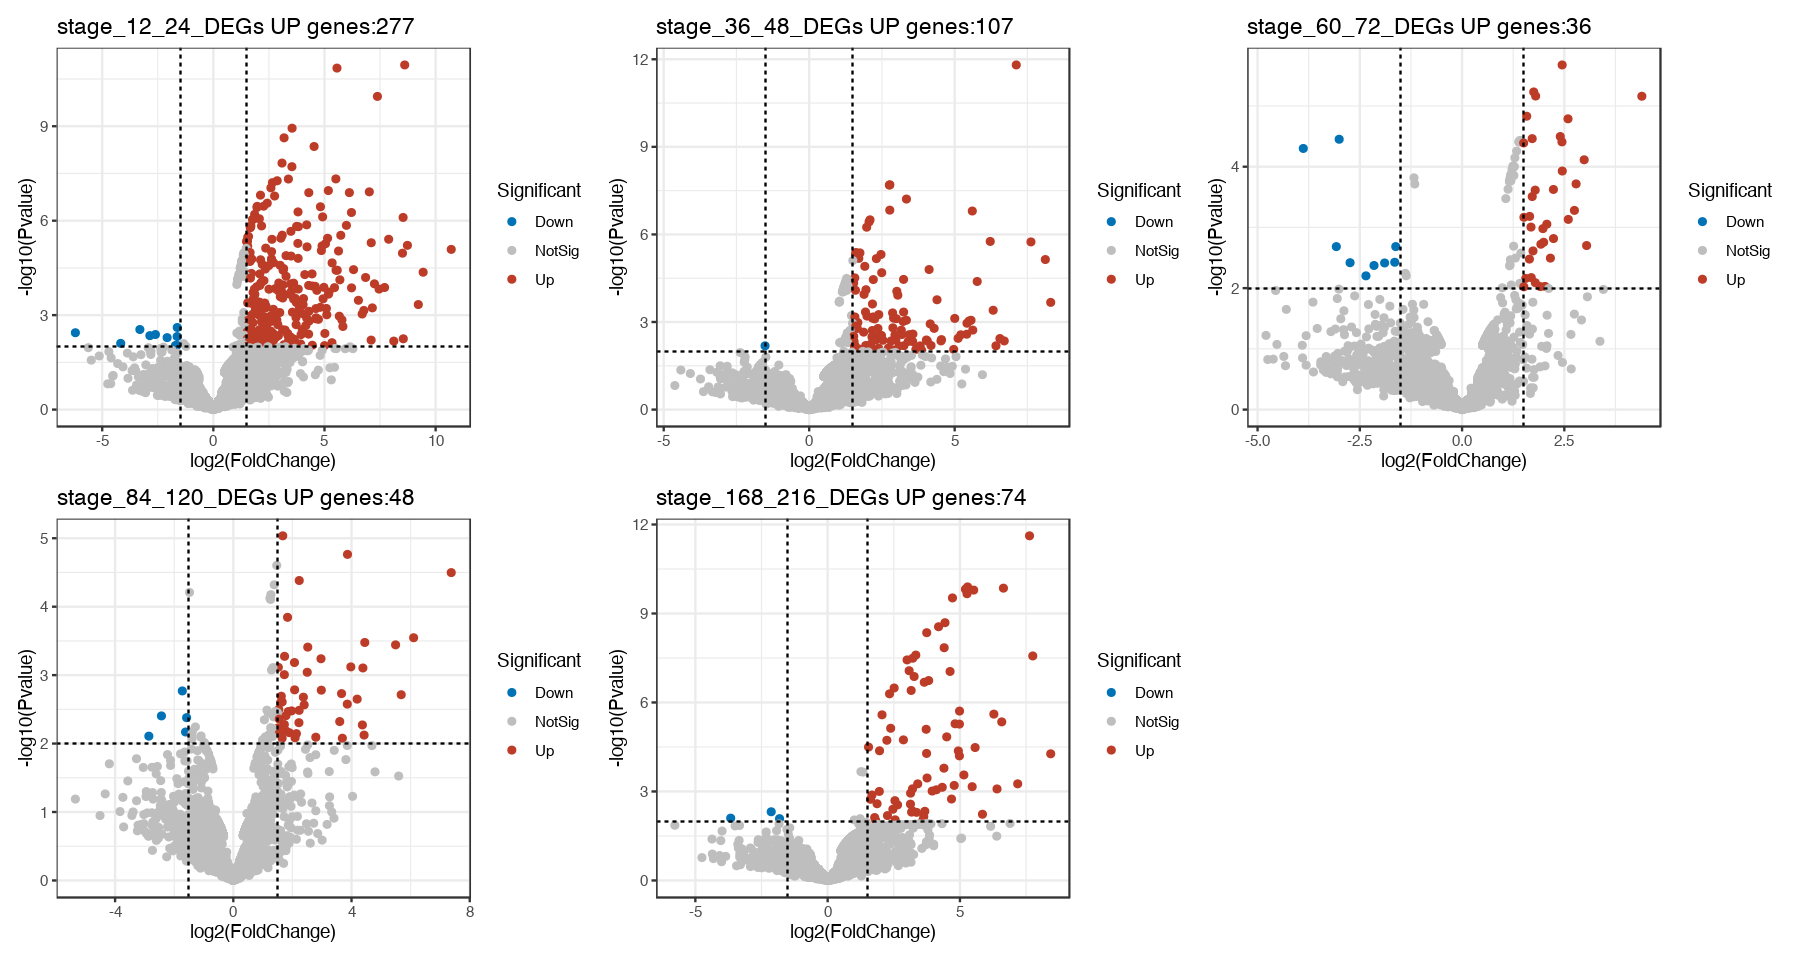

In [118]:
options(repr.plot.width=15, repr.plot.height=8)
#pdf('CC_stage_specific_DEGs.pdf',width = 15, height = 8)

foldChange <- 1.5
pvalue <- 0.01
p1 <- volcano(stage_12_24_DEG, foldChange=foldChange, padj = pvalue, title="stage_12_24_DEGs") 
p2 <- volcano(stage_36_48_DEG, foldChange=foldChange, padj = pvalue, title="stage_36_48_DEGs") 
p3 <- volcano(stage_60_72_DEG, foldChange=foldChange, padj = pvalue, title="stage_60_72_DEGs") 
p4 <- volcano(stage_84_120_DEG, foldChange=foldChange, padj = pvalue, title="stage_84_120_DEGs") 
p5 <- volcano(stage_168_216_DEG, foldChange=foldChange, padj = pvalue, title="stage_168_216_DEGs") 

p1+p2+p3+p4+p5
#dev.off()

In [131]:
get_stage_DE_marker_gene <- function(df, FC, pavalue){
    top_gene <- df %>%
        arrange(logFC) %>%
        filter(P.Value<pavalue, logFC>FC)
        #top_n(n = 100, wt = logFC)
    return(rownames(top_gene))
}

CCstage_1_genes <- get_stage_DE_marker_gene(stage_12_24_DEG, foldChange, pvalue)
CCstage_2_genes <- get_stage_DE_marker_gene(stage_36_48_DEG, foldChange, pvalue)
CCstage_3_genes <- get_stage_DE_marker_gene(stage_60_72_DEG, foldChange, pvalue)
CCstage_4_genes <- get_stage_DE_marker_gene(stage_84_120_DEG, foldChange, pvalue)
CCstage_5_genes <- get_stage_DE_marker_gene(stage_168_216_DEG, foldChange, pvalue)

CC_stage_gene_list <- list(CCstage_1_genes,
                           CCstage_2_genes,
                           CCstage_3_genes,
                           CCstage_4_genes,
                           CCstage_5_genes
                          )

In [218]:
geneIDTransForm <- read.table("~/Documents/phd/tomato_metabolic/geneIDTransForm/mart_export.txt", sep="\t", header=TRUE)

id2entrezID <- function(ids){
    #df <- geneIDTransForm[geneIDTransForm$NCBI.gene..formerly.Entrezgene..ID,]
    Entreids <- unique(geneIDTransForm[geneIDTransForm$Gene.stable.ID %in% ids,]$NCBI.gene..formerly.Entrezgene..ID)
    return(Entreids)
}

cluster_gene_go <- function(entirz, clusteri){
    cluster_erich.go = enrichGO(gene = entirz,
                       OrgDb = Solanum.OrgDb,
                       keyType = "ENTREZID",
                       ont = "BP",
                       pvalueCutoff = 0.5,
                       qvalueCutoff = 0.5)
    
    df <- cluster_erich.go@result
    df$Group <- clusteri
    df <- subset(df, select = c("Group", "Description", "pvalue", "GeneRatio"))
    colnames(df) <- c("group", "Description", "pvalue", "ratio")
    return (df)
}

stage2go <- function(FCdata){
    clusters <- unique(FCdata$cluster)
    
    all_cluster_go <- data.frame()
    
    for (cl in clusters){
        sub_cm_genes <- subset(FCdata, cluster==cl, select=c("gene"))
        sub_cm_entriz <- id2entrezID(sub_cm_genes$gene)

        cluster_go <- cluster_gene_go(sub_cm_entriz, paste0("S", cl))
        
        if (dim(all_cluster_go)[1]==0){
            all_cluster_go <- cluster_go
        }else{
            all_cluster_go = rbind(all_cluster_go, cluster_go)
        }
    }
    
    return (all_cluster_go)
}



In [259]:
stage_gene_list <- CC_stage_gene_list
cm <- CC_FC_cm

#clusters <- names(stage_gene_list)
all_genes <- unique(as.vector(unlist(stage_gene_list)))
data <- subset(cm$wide.res, gene %in% all_genes)

rownames(data) <- data$gene
for (i in 1:length(stage_gene_list)){
    data[stage_gene_list[[i]], "cluster"] = i
}


cl.info <- data.frame(table(data$cluster)) %>%
  dplyr::arrange(Var1)
cluster.num <- nrow(cl.info)

subgroup <- lapply(1:nrow(cl.info),function(x){
  nm <- rep(as.character(cl.info$Var1[x]),cl.info$Freq[x])
  paste("S",nm,sep = '')
}) %>% unlist()


subgroup <- factor(subgroup, levels=paste0("S",cl.info$Var1))

mat <- data[order(data$cluster),]
mat <- mat %>%
      dplyr::arrange(cluster) %>%
      dplyr::select(-gene,-cluster,-membership)

align_to = split(1:nrow(mat), subgroup)
align_to = align_to[paste0("S", cl.info$Var1)]

colanno <- jjAnno::useMyCol("stallion",n = cluster.num)

anno.block <- ComplexHeatmap::anno_block(align_to = align_to,
                                             panel_fun = function(index, nm) {
                                               npos = as.numeric(unlist(strsplit(nm,split = "S"))[2])

                                               # rect
                                               grid::grid.rect(gp = grid::gpar(fill = colanno[npos],col = NA))

                                               # text
                                               
                                             grid::grid.text(label = paste("n:",length(index),sep = ''),
                                                             rot = 90,
                                                             gp = grid::gpar(col = c("white",8)[1],
                                                                             fontsize = as.numeric(c("white",14)[2])))
                                            
                                             },
                                             which = "row")


[1] "This palatte have 20 colors!"


In [220]:
annoTerm.data <- stage2go(data)

In [268]:
TopAnnoTerm.data <- annoTerm.data %>% group_by(group) %>% slice_head(n = 7)

In [271]:

# add to termanno
termanno <- TopAnnoTerm.data


colnames(termanno) <- c("id","term","pval","ratio")
#gocol <- circlize::rand_color(n = 7)
termanno$col = rep(ggsci::pal_d3("category20")(unique(data$cluster)),each = 7)
#termanno <- termanno %>%
#                dplyr::mutate(col = gocol)

termanno$fontsize = 14
termanno$bary <- -log10(termanno$pval)

# to list
lapply(1:length(unique(termanno$id)), function(x){
  tmp = termanno[which(termanno$id == unique(termanno$id)[x]),]
  df <- data.frame(text = tmp$term,
                   col = tmp$col,
                   fontsize = tmp$fontsize)
  return(df)
}) -> term.list

# add names
names(term.list) <- unique(termanno$id)


Warning message in if (n > n_values) {:
“条件的长度大于一，因此只能用其第一元素”
Warning message in seq_len(n):
“只用'length.out'参数里的第一个元素”


In [303]:
termAnno.arg = c("grey95","grey50")

panel_FUN <- function(index, nm){
    textbar.pos = c(0.8, 0.2)
    
    grid::pushViewport(grid::viewport(xscale = c(0,1),yscale = c(0,1)))
    grid::grid.rect()
    
    data <- termanno
    
    tmp <- data %>%
        dplyr::filter(id == nm) %>%
        dplyr::arrange(bary)

    # bar grobs
    # grid::grid.rect(x = rep(0,nrow(tmp)),
    #                 y = scales::rescale(1:nrow(tmp),to = c(0,1)),
    #                 width = scales::rescale(tmp$log10P,to = c(0,1)),
    #                 height = bar.width,
    #                 gp = grid::gpar(fill = tmp$col,col = col))

    grid::grid.segments(x0 = rep(0,nrow(tmp)),
                        x1 = scales::rescale(tmp$bary,to = c(0,1)),
                        y0 = scales::rescale(1:nrow(tmp),to = c(0,1)),
                        y1 = scales::rescale(1:nrow(tmp),to = c(0,1)),
                        gp = grid::gpar(lwd = 8,
                                        col = tmp$col,
                                        lineend = "butt"))

    # add cluster name
    grid.textbox <- utils::getFromNamespace("grid.textbox", "ComplexHeatmap")

    text <- nm
    grid.textbox(text,
                 x = textbar.pos[1],y = textbar.pos[2],
                 gp = grid::gpar(fontsize = 8,
                                 fontface = "italic",
                                 col = unique(tmp$col)))

    grid::popViewport()
  }

baranno <- ComplexHeatmap::anno_zoom(align_to = align_to,
                                      which = "row",
                                      # =====================
                                      panel_fun = panel_FUN,
                                      # =======================
                                      size = grid::unit(as.numeric(panel.arg[1]), "cm"),
                                      gap = grid::unit(as.numeric(panel.arg[2]), "cm"),
                                      width = grid::unit(as.numeric(panel.arg[3]), "cm"),
                                      side = "right",
                                      link_gp = grid::gpar(fill = termAnno.arg[1],col = termAnno.arg[2]))
    
panel.arg = c(2,0.25,4,"grey90",NA)


In [307]:
options(repr.plot.width=10, repr.plot.height=8)
pdf(paste0("CC_mfuzz_cluster_main_gene_stage_specific_DEGs.pdf"), width = 10, height = 8, onefile = T)


right_annotation = ComplexHeatmap::rowAnnotation(gene = NULL,cluster = anno.block)
panel.arg = c(2,0.25,4,"grey90",NA)

left_annotation = ComplexHeatmap::rowAnnotation(cluster = anno.block)

textbox = ComplexHeatmap::anno_textbox(subgroup, term.list,
                                               word_wrap = TRUE,
                                               add_new_line = TRUE,
                                               side = 'right',
                                               background_gp = grid::gpar(fill = c("grey95","grey50")[1],
                                                                          col = c("grey95","grey50")[2]))
right_annotation = ComplexHeatmap::rowAnnotation(textbox = textbox, bar = baranno)


htf <- ComplexHeatmap::Heatmap(as.matrix(mat),
                                     name = "Z-score",
                                     cluster_columns = FALSE,
                                     cluster_rows = FALSE,
                                     show_row_names = FALSE,
                                     border = TRUE,
                                     #column_split = column_split,
                                     #top_annotation = topanno,
                                     right_annotation = right_annotation,
                                     left_annotation = left_annotation,
                                     column_names_side = "top",
                                     row_split = subgroup,
                                     column_names_rot=45,
                                     #col = col_fun,
                                     )



ComplexHeatmap::draw(htf,merge_legend = TRUE)
dev.off()

pdf 
  2

In [204]:
stage_clusterFC_cm <- function(cm, stage_gene_list){
    clusters <- names(stage_gene_list)
    all_genes <- unique(as.vector(unlist(stage_gene_list)))
    data <- subset(cm$wide.res, gene %in% all_genes)
    
    cl.info <- data.frame(table(data$cluster)) %>%
      dplyr::arrange(Var1)
    cluster.num <- nrow(cl.info)

    subgroup <- lapply(1:nrow(cl.info),function(x){
      nm <- rep(as.character(cl.info$Var1[x]),cl.info$Freq[x])
      paste("C",nm,sep = '')
    }) %>% unlist()

    print(unique(subgroup))

    print(cl.info$Var1)
    subgroup <- factor(subgroup, levels=paste0("C",cl.info$Var1))
    
    
    
    clusters <- names(stage_gene_list)
    all_genes <- unique(as.vector(unlist(stage_gene_list)))
    cm$wide.res <- subset(cm$wide.res, gene %in% all_genes)
    cm$long.res <- subset(cm$long.res, gene %in% all_genes)
    
    for (i in clusters){
        cm$wide.res[cm$wide.res$gene %in% stage_gene_list[[i]], "cluster"] = i
    }
    
    
    
    
}


In [139]:
head(CC_FC_cm$long.res)

,cluster,gene,membership,cell_type,norm_value,cluster_name
,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>
1,1,novel.1295,0.9547460,HAG12,-1.3882463,cluster 1 (631)
2,1,novel.1358,0.7515361,HAG12,-1.0045513,cluster 1 (631)
3,1,novel.1445,0.8032399,HAG12,-1.2126530,cluster 1 (631)
4,1,novel.6315,0.6234819,HAG12,-0.7410972,cluster 1 (631)
5,1,novel.6318,0.2934663,HAG12,-0.5085009,cluster 1 (631)
6,1,novel.829,0.8641405,HAG12,-0.9158649,cluster 1 (631)
